In [1]:

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import pathlib
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

from keras.utils import plot_model
from imblearn.over_sampling import SMOTE
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from tensorflow.keras.applications import ResNet50V2, VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array

c:\Users\samee\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
folder = 'BreaKHis_v1/histology_slides/breast'
folder_path = pathlib.Path(folder)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x12E554DEAD0>


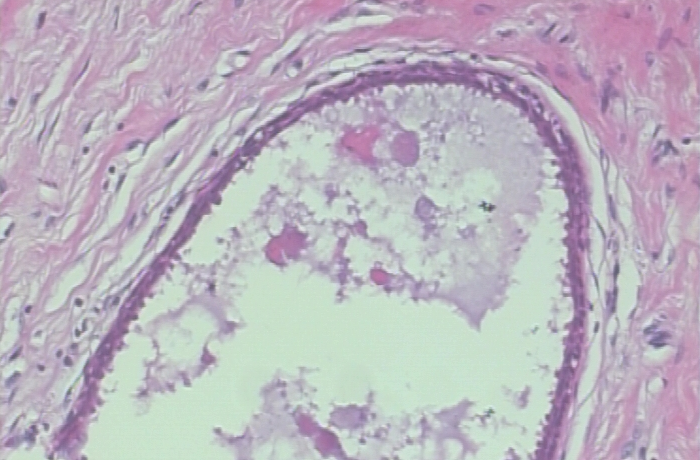

In [3]:
photo = load_img('BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png')
print(photo)
photo

In [4]:
IMG_SIZE = 128
DIM = (IMG_SIZE, IMG_SIZE)

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

In [5]:
train_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)
train_data_gen = train_generator.flow_from_directory(directory=folder, target_size=DIM, batch_size=6500, shuffle=False)

Found 7909 images belonging to 2 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

print(train_data.shape, train_labels.shape)

(8040, 49152) (8040, 1)


In [8]:
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(8040, 128, 128, 3) (8040, 1)


In [9]:
train_labels = train_labels.reshape(-1, 1)

c:\Users\samee\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


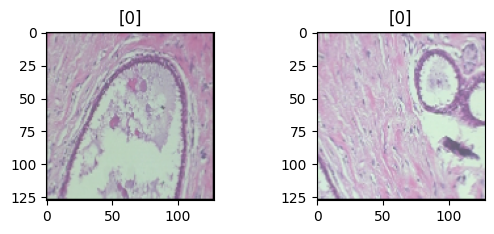

In [10]:
for i in range(2):
    plt.subplot(2,2,1+i)
    plt.title(train_labels[i])
    plt.imshow(train_data[i])

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
train_data, test_data, train_labels,test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

train_data, val_data, train_labels,val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [13]:
from keras.layers import MaxPool2D


act = 'relu'
IMAGE_SIZE = (128, 128)

cnn_model = Sequential([
Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
Conv2D(16, 3, activation=act, padding='same'),
Conv2D(16, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(32, 3, activation=act, padding='same'),
Conv2D(32, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
Conv2D(64, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
Conv2D(128, 3, activation=act, padding='same'),
BatchNormalization(),
    MaxPool2D(),
Dropout(0.2),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
Conv2D(256, 3, activation=act, padding='same'),
BatchNormalization(),
MaxPool2D(),
Dropout(0.2),
Flatten(),
Dense(512, activation=act),
BatchNormalization(),
Dropout(0.7),
Dense(128, activation=act),
BatchNormalization(),
Dropout(0.5),
Dense(64, activation=act),
BatchNormalization(),
Dropout(0.3),
Dense(1, activation='sigmoid')
], name='cnn_model')

In [14]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        92

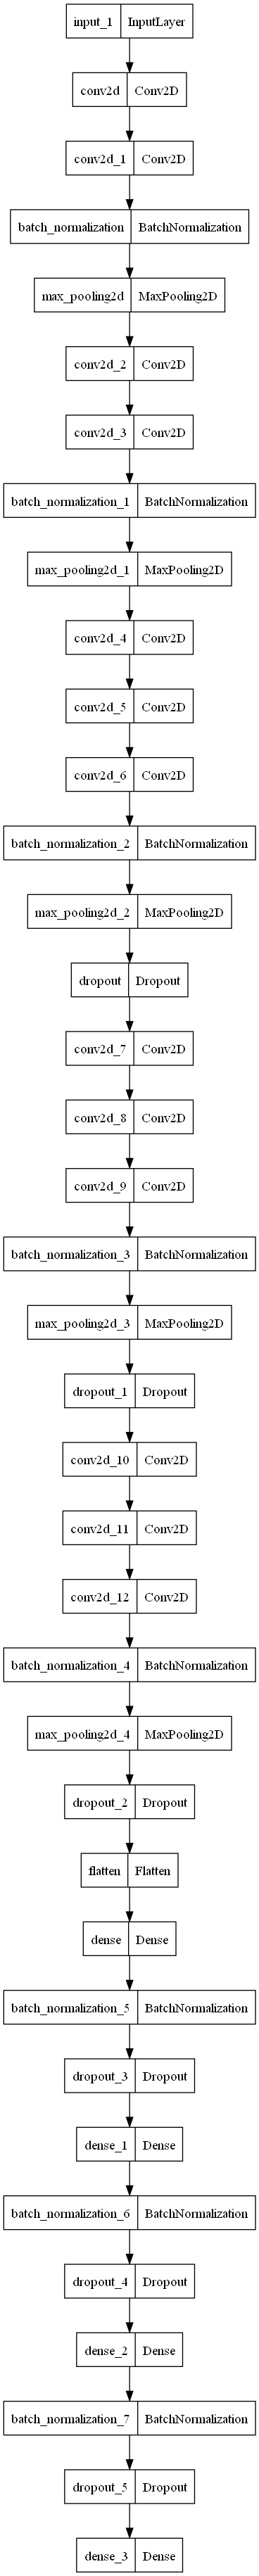

In [15]:
plot_model(cnn_model)

In [16]:
tf.keras.backend.set_image_data_format('channels_first')

In [17]:
# Fit the model to the training data
history = cnn_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
cnn_accuracy_history = history.history['accuracy']
cnn_loss_history = history.history['loss']

Epoch 1/50
161/161 [==============================] - 179s 1s/step - loss: 0.6162 - accuracy: 0.7254
Epoch 2/50
161/161 [==============================] - 168s 1s/step - loss: 0.4934 - accuracy: 0.7903
Epoch 3/50
161/161 [==============================] - 170s 1s/step - loss: 0.4442 - accuracy: 0.8187
Epoch 4/50
161/161 [==============================] - 172s 1s/step - loss: 0.4154 - accuracy: 0.8200
Epoch 5/50
161/161 [==============================] - 170s 1s/step - loss: 0.4030 - accuracy: 0.8301
Epoch 6/50
161/161 [==============================] - 160s 995ms/step - loss: 0.3851 - accuracy: 0.8311
Epoch 7/50
161/161 [==============================] - 172s 1s/step - loss: 0.3708 - accuracy: 0.8334
Epoch 8/50
161/161 [==============================] - 175s 1s/step - loss: 0.3558 - accuracy: 0.8447
Epoch 9/50
161/161 [==============================] - 166s 1s/step - loss: 0.3372 - accuracy: 0.8620
Epoch 10/50
161/161 [==============================] - 164s 1s/step - loss: 0.3241 - acc

In [20]:
loss, accuracy = cnn_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 6s 103ms/step - loss: 0.3268 - accuracy: 0.8912
Accuracy: 89.12%


In [21]:
y_pred = np.round(cnn_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

cnn_precision = avg_precision
cnn_recall = avg_recall
cnn_f1score = avg_f1_score


51/51 [==============================] - 5s 102ms/step
Average Precision: 89.34%
Average Recall: 89.12%
Average F1 Score: 89.11%


51/51 [==============================] - 5s 96ms/step


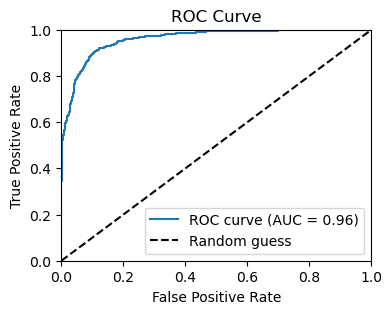

In [22]:
# Get predicted probabilities for test set
y_pred_prob = cnn_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 5s 102ms/step


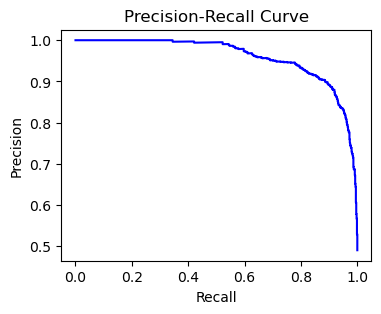

In [23]:
y_scores = cnn_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

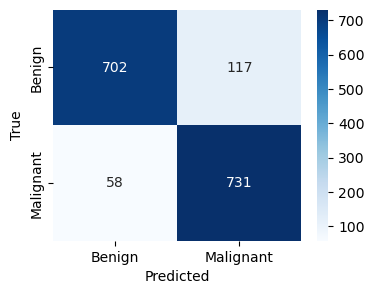

In [24]:
# your code here
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
from keras import backend as K

K.set_image_data_format('channels_last')
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 9s 0us/step


In [26]:
for layer in vgg_model.layers:
    layer.trainable = False

In [27]:
vgg16_model = Sequential([
    vgg_model,
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')        
], name="vgg16_model")

In [28]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()

Model: "vgg16_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_8 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 512)               

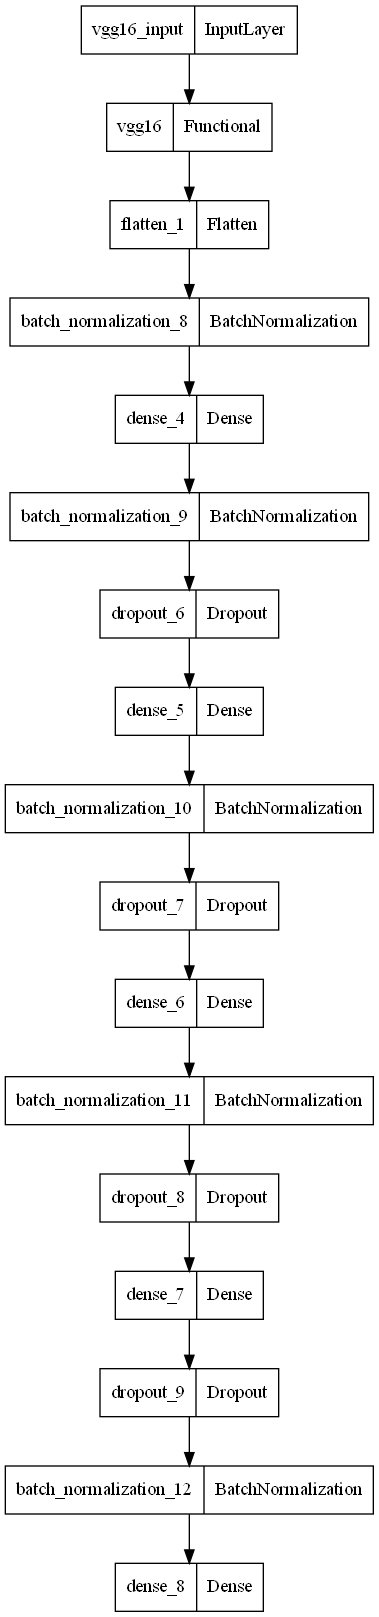

In [29]:
plot_model(vgg16_model)

In [30]:
# Fit the model to the training data
vgg16_history = vgg16_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
vgg16_accuracy_history = vgg16_history.history['accuracy']
vgg16_loss_history = vgg16_history.history['loss']

Epoch 1/50
161/161 [==============================] - 123s 747ms/step - loss: 0.7428 - accuracy: 0.5854
Epoch 2/50
161/161 [==============================] - 123s 767ms/step - loss: 0.5521 - accuracy: 0.7300
Epoch 3/50
161/161 [==============================] - 132s 821ms/step - loss: 0.4301 - accuracy: 0.8103
Epoch 4/50
161/161 [==============================] - 130s 808ms/step - loss: 0.3721 - accuracy: 0.8402
Epoch 5/50
161/161 [==============================] - 134s 833ms/step - loss: 0.3255 - accuracy: 0.8709
Epoch 6/50
161/161 [==============================] - 132s 822ms/step - loss: 0.2636 - accuracy: 0.8931
Epoch 7/50
161/161 [==============================] - 131s 816ms/step - loss: 0.2560 - accuracy: 0.8999
Epoch 8/50
161/161 [==============================] - 136s 847ms/step - loss: 0.2322 - accuracy: 0.9067
Epoch 9/50
161/161 [==============================] - 131s 814ms/step - loss: 0.1926 - accuracy: 0.9254
Epoch 10/50
161/161 [==============================] - 134s 832m

In [31]:
loss, accuracy = vgg16_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 38s 722ms/step - loss: 0.5204 - accuracy: 0.8539
Accuracy: 85.39%


In [32]:
y_pred = np.round(vgg16_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

vgg16_precision = avg_precision
vgg16_recall = avg_recall
vgg16_f1score = avg_f1_score

51/51 [==============================] - 39s 750ms/step
Average Precision: 85.52%
Average Recall: 85.39%
Average F1 Score: 85.36%


51/51 [==============================] - 39s 771ms/step


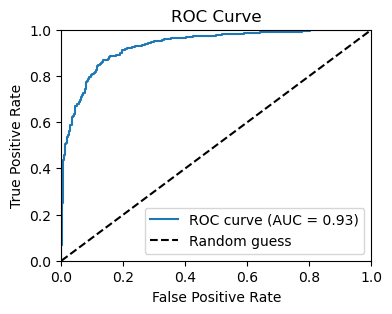

In [33]:
# Get predicted probabilities for test set
y_pred_prob_tl = vgg16_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob_tl)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob_tl)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 39s 767ms/step


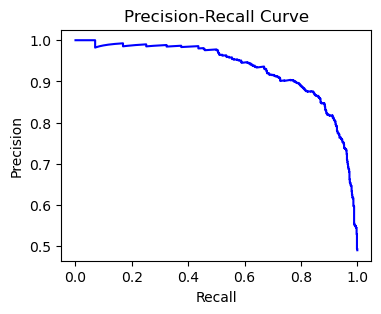

In [34]:
y_scores = vgg16_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [35]:
# Load the pre-trained ResNet50V2 model
resnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Freeze the layers in the pre-trained model
for layer in resnet50v2.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 13s 0us/step


In [36]:
ResNet50V2_model = Sequential([
    resnet50v2,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="ResNet50V2_model")

In [37]:
ResNet50V2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ResNet50V2_model.summary()

Model: "ResNet50V2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               16777728  
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                  

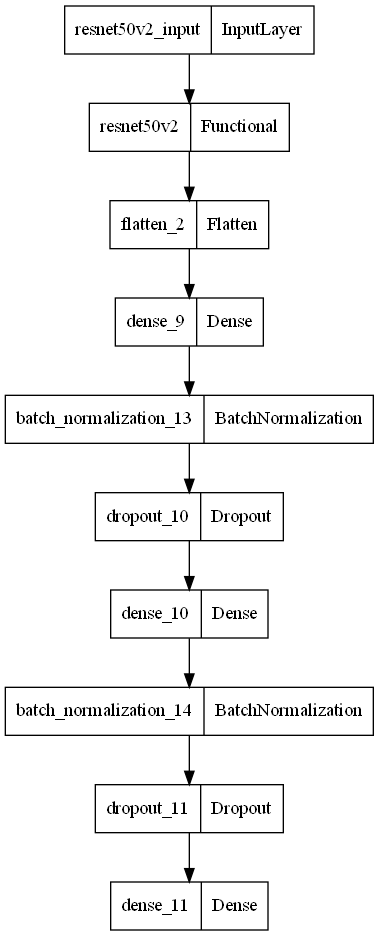

In [38]:
plot_model(ResNet50V2_model)

In [39]:
ResNet50V2_model_history = ResNet50V2_model.fit(train_data, train_labels, epochs=50, verbose=1)

# Store accuracy and loss history for each epoch
ResNet_accuracy_history = ResNet50V2_model_history.history['accuracy']
ResNet_loss_history = ResNet50V2_model_history.history['loss']

Epoch 1/50
161/161 [==============================] - 74s 430ms/step - loss: 0.6237 - accuracy: 0.7308
Epoch 2/50
161/161 [==============================] - 66s 412ms/step - loss: 0.3757 - accuracy: 0.8369
Epoch 3/50
161/161 [==============================] - 67s 414ms/step - loss: 0.2664 - accuracy: 0.8912
Epoch 4/50
161/161 [==============================] - 67s 416ms/step - loss: 0.2248 - accuracy: 0.9081
Epoch 5/50
161/161 [==============================] - 66s 412ms/step - loss: 0.1690 - accuracy: 0.9296
Epoch 6/50
161/161 [==============================] - 66s 412ms/step - loss: 0.1254 - accuracy: 0.9489
Epoch 7/50
161/161 [==============================] - 67s 419ms/step - loss: 0.1207 - accuracy: 0.9551
Epoch 8/50
161/161 [==============================] - 69s 429ms/step - loss: 0.1186 - accuracy: 0.9561
Epoch 9/50
161/161 [==============================] - 66s 412ms/step - loss: 0.0976 - accuracy: 0.9613
Epoch 10/50
161/161 [==============================] - 67s 416ms/step - l

In [40]:
loss, accuracy = ResNet50V2_model.evaluate(test_data, test_labels)
print("Accuracy: {:.2f}%".format(accuracy*100))

51/51 [==============================] - 21s 387ms/step - loss: 0.7019 - accuracy: 0.8576
Accuracy: 85.76%


In [41]:
y_pred = np.round(ResNet50V2_model.predict(test_data)).astype(int)

target_names = ['Benign', 'Malignant']
report = classification_report(test_labels, y_pred, target_names=target_names, output_dict=True)

for target_name in target_names:
    precision = report[target_name]['precision']
    recall = report[target_name]['recall']
    f1_score = report[target_name]['f1-score']
  
# Average precision, recall, and F1-score
avg_precision = report['weighted avg']['precision']
avg_recall = report['weighted avg']['recall']
avg_f1_score = report['weighted avg']['f1-score']

print('Average Precision: {:.2f}%'.format(avg_precision*100))
print('Average Recall: {:.2f}%'.format(avg_recall*100))
print('Average F1 Score: {:.2f}%'.format(avg_f1_score*100))

ResNet_precision = avg_precision
ResNet_recall = avg_recall
ResNet_f1score = avg_f1_score

51/51 [==============================] - 19s 363ms/step
Average Precision: 86.03%
Average Recall: 85.76%
Average F1 Score: 85.75%


51/51 [==============================] - 19s 378ms/step


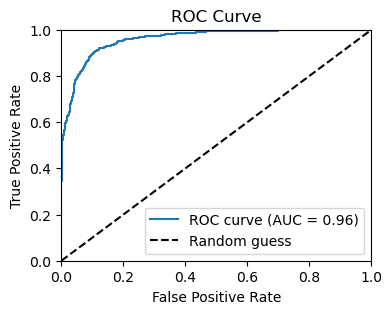

In [42]:
# Get predicted probabilities for test set
y_pred = ResNet50V2_model.predict(test_data)

# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_prob)

# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

51/51 [==============================] - 19s 365ms/step


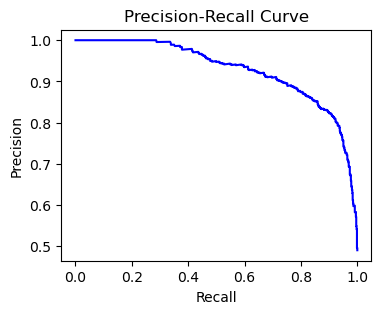

In [43]:
y_scores = ResNet50V2_model.predict(test_data)
precision, recall, _ = precision_recall_curve(test_labels, y_scores)

plt.figure(figsize=(4,3)) # set figure size
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [44]:
# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_data, test_labels)

# Evaluate the VGG16 model
vgg16_loss, vgg16_accuracy = vgg16_model.evaluate(test_data, test_labels)

# Evaluate the ResNet50V2 model
resnet_loss, resnet_accuracy = ResNet50V2_model.evaluate(test_data, test_labels)

print('+-------------------------------------------------------+')
print('|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |')
print('+-----------------+---------------+---------------------+')
print(f'|    {"CNN Model":<15} |    {cnn_loss:.2f}      |        {cnn_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'|   {"VGG16 Model":<15} |    {vgg16_loss:.2f}      |        {vgg16_accuracy:.2f}        |')
print('+-----------------+---------------+---------------------+')


print(f'| {"ResNet50V2 Model":<15} |    {resnet_loss:.2f}      |        {resnet_accuracy:.2f}         |')
print('+-----------------+---------------+---------------------+')

51/51 [==============================] - 19s 374ms/step - loss: 0.7019 - accuracy: 0.8576
+-------------------------------------------------------+
|{"Model Evaluation Results"} |   {"loss"} | {"accuracy"}             |
+-----------------+---------------+---------------------+
|    CNN Model       |    0.33      |        0.89        |
+-----------------+---------------+---------------------+
|   VGG16 Model     |    0.52      |        0.85        |
+-----------------+---------------+---------------------+
| ResNet50V2 Model |    0.70      |        0.86         |
+-----------------+---------------+---------------------+


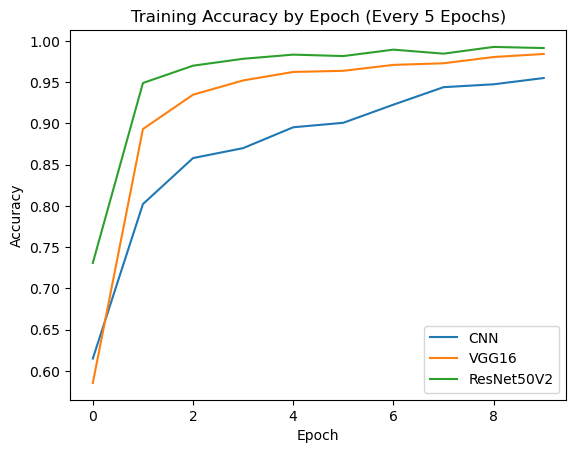

In [45]:
# Extract the accuracy history for each model every 5 epochs
cnn_history = cnn_accuracy_history[::5]
vgg16_history = vgg16_accuracy_history[::5]
resnet_history = ResNet_accuracy_history[::5]

# Plot the accuracy history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Accuracy by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

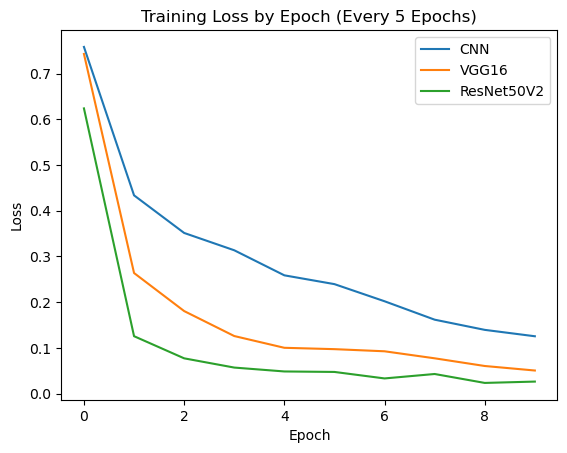

In [46]:
# Extract the loss history for each model every 5 epochs
cnn_history = cnn_loss_history[::5]
vgg16_history = vgg16_loss_history[::5]
resnet_history = ResNet_loss_history[::5]

# Plot the loss history for each model
plt.plot(cnn_history, label='CNN')
plt.plot(vgg16_history, label='VGG16')
plt.plot(resnet_history, label='ResNet50V2')

# Set the plot title and axis labels
plt.title('Training Loss by Epoch (Every 5 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

In [47]:
# Create a dictionary to store the metrics
metrics_dict = {
    'Model': ['CNN', 'VGG16', 'ResNet50V2'],
   'Avg Precision': [cnn_precision*100, vgg16_precision*100, ResNet_precision*100],
        'Avg Recall': [cnn_recall*100, vgg16_recall*100, ResNet_recall*100],
        'Avg F1-Score': [cnn_f1score*100, vgg16_f1score*100, ResNet_f1score*100]
}

# Create a pandas DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Print the DataFrame
print(metrics_df)

        Model  Avg Precision  Avg Recall  Avg F1-Score
0         CNN      89.343140   89.116915     89.109711
1       VGG16      85.522345   85.385572     85.360642
2  ResNet50V2      86.030308   85.758706     85.745045
